# Latent Dirichlet Allocation and Coordinate Ascent Variational Inference


**STATS 305C: Applied Statistics III**

_Stanford University. Spring, 2022._


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slinderman/stats305c/blob/master/notebooks/lecture9_lda_cavi.ipynb)


---

Recall the following generatize model for LDA. Suppose we have $K$ topics and $N$ documents.

For each topic $k \leq K$, draw a topic 
$$\theta_k \sim \text{Dir}(\phi)$$

Then, for each document $n \leq N$, draw topic proportions 
$$\pi_n \sim \text{Dir}(\alpha)$$

Finally, for each word $l$ in document $n$, first draw a topic assignment 
$$
z_{n,d} \mid \pi_n \sim \text{Cat}(\pi_n)
$$
and draw a word
$$
x_{n,d} \mid z_{n,d} \sim \text{Cat}(\theta_{z_{n,d}})
$$

As mentioned in class, while this formulation is easier to present, it's more efficient to represent the documents as sparse vectors of _word counts_, $\mathbf{y}_n \in \mathbb{N}^V$ where $y_{n,v} = \sum_{d=1}^D \mathbb{I}[x_{n,d} = v]$. 

This notebook studies Federalist papers in their entirety. We've provided a $N \times V$ dataframe of the essays represented as word counts. The rows of the data frame correspond to the 85 individual essays and the columns correspond to the 5320 words in the vocabulary. We have already preprocessed the raw essays to remove very common and very infrequent words.

Using this data, we will fit a topic model and do some analysis.

In [1]:
import torch
from torch.distributions import Dirichlet, Multinomial, Categorical
import pandas as pd 

import matplotlib.pyplot as plt
from tqdm.auto import trange

## Load the data

We've already tokenized the text and created a bag-of-words representation of the corpus. We removed words from the vocabulary that occur in more than 95% of the essays or only appear in 1 essay.

In [30]:
# Download the data
!wget -nc https://www.dropbox.com/s/p6jb2cw5w5626pl/tokenized_fed.csv
!wget -nc https://www.dropbox.com/s/ftedra0jyk1j3hx/authorship.csv

File ‘tokenized_fed.csv’ already there; not retrieving.

--2022-04-25 17:57:31--  https://www.dropbox.com/s/ftedra0jyk1j3hx/authorship.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ftedra0jyk1j3hx/authorship.csv [following]
--2022-04-25 17:57:32--  https://www.dropbox.com/s/raw/ftedra0jyk1j3hx/authorship.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5438ddee2f1ee9c669b5cd2e73.dl.dropboxusercontent.com/cd/0/inline/BkFfSjhYT-eVBzEEhoTcPZ9SYk13Jjx_nHVCDii1hoRe6NUZe-x72hiey2J3LddrHNqEdu_Qgs9wR4MnDUJzpxjbWOch2bOG4dJZsg-rgrlkdaYDQTmM8YBu6TY6ALJggynfhE2hE2NMnP6MOApMIhQJcmQTR2pab5Lfl2SSfR17kA/file# [following]
--2022-04-25 17:57:32--  https://uc5438ddee2f1ee9c669b5cd2e73.dl.dropboxusercontent.com/cd/0/inline/BkFfS

In [3]:
# Load the data
df = pd.read_csv('tokenized_fed.csv', index_col = 0)
docs = torch.tensor(df.to_numpy()).type(torch.int)
vocab = df.columns.to_list()
df

,unequivocal,experience,inefficacy,subsisting,federal,called,deliberate,new,constitution,united,...,chancery,jurisprudence,reexamination,writ,commonlaw,intent,refutation,habeas,corpus,clerks
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.0,0.0,0.0,0.0,6.0,1.0,1.0,8.0,12.0,8.0,...,1.0,1.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
81,0.0,0.0,0.0,0.0,12.0,0.0,0.0,2.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
82,0.0,1.0,0.0,0.0,7.0,2.0,2.0,9.0,13.0,6.0,...,7.0,1.0,1.0,0.0,5.0,2.0,2.0,1.0,1.0,1.0
83,0.0,0.0,0.0,0.0,2.0,1.0,0.0,9.0,26.0,12.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,3.0,1.0


## Write some helper fucntions for Dirichlet distributions

Specifically, we need the expected log of a Dirichlet random vector and the KL divergence between two Dirichlet random variables.

In [15]:
def dirichlet_expected_log(dirichlet):
    """Helper function to compute expected log under Dirichlet distribution.

    Args:
        dirichlet: A torch.distributions.Dirichlet object with a batch shape of
            (...,) and a event shape of (K,).

    Returns:
        (...,K) tensor of expected logs, E[\log \pi], under the Dirichlet.
    """
    concentration = dirichlet.concentration
    return torch.special.digamma(concentration) - \
           torch.special.digamma(concentration.sum(dim=-1, keepdims=True))


def dirichlet_log_normalizer(concentration):
    """Compute the log normalizing constant of a Dirichlet distribution with
    the specificed concentration.

    Args:
        concentration: (...,K) tensor of concentration parameters

    Returns:
        (...,) batch of log normalizers
    """
    return torch.special.gammaln(concentration).sum(dim=-1) - \
        torch.special.gammaln(concentration.sum(dim=-1))

def dirichlet_kl(q, p):
    """Compute the KL divergence between two Dirichlet disdtributions

    Args:
        q: A torch.distributions.Dirichlet object
        p: A torch.distributions.Dirichlet object over the same domain

    Returns:
        A (batch of) KL divergence(s) between q and p.
    """
    kl = -dirichlet_log_normalizer(q.concentration)
    kl += dirichlet_log_normalizer(p.concentration)
    kl += torch.sum((q.concentration - p.concentration) * \
                    dirichlet_expected_log(q), dim=-1)
    return kl

## Implement Coordinate Ascent Variational Inference (CAVI)

_Note: The `torch.distributions.Multinomial` object doesn't work well when you have a batch with different numbers of counts. We hijack this object by not giving it a count so that it defaults to 1, which is equivalent to a categorical distribution. Then we multiply by the total counts to get the necessary expectations under the multinomial posterior._

In [18]:
def cavi(docs, 
         num_topics=10, 
         num_iters=200, 
         tol=1e-5, 
         alpha=20.0, 
         phi=1.0,
         seed=305 + ord('c'),
        ):
    """Run coordinate ascent VI for LDA.
    
    """
    docs = docs.type(torch.float)
    N, V = docs.shape
    K = num_topics      # short hand
    
    def cavi_step(q_c, q_pi, q_theta):
        """One step of CAVI.
        """
        # Update the topic assignment counts
        E_logpi = dirichlet_expected_log(q_pi)
        E_logtheta = dirichlet_expected_log(q_theta)
        q_c = Multinomial(logits=E_logpi[:, None, :] + E_logtheta.T)
        
        # Compute the mean of q(c) since we'll use it twice below
        E_c = docs.unsqueeze(2) * q_c.mean
        
        # Update the topic proportions
        q_pi = Dirichlet(alpha + E_c.sum(axis=1))
        
        # Update the topic word probabilities
        q_theta = Dirichlet(phi + E_c.sum(axis=0).T)
        
        return q_c, q_pi, q_theta
    
    def elbo(q_c, q_pi, q_theta):
        """Compute the evidence lower bound.
        """
        elbo = 0
        
        # KL to prior
        elbo -= dirichlet_kl(q_pi, Dirichlet(alpha * torch.ones(K))).sum()
        elbo -= dirichlet_kl(q_theta, Dirichlet(phi * torch.ones(V))).sum()
        
        # Entropy of q(z) [a little different from multinomial entropy]
        E_c = docs.unsqueeze(2) * q_c.mean
        elbo -= torch.sum(E_c * torch.log(q_c.probs))
        
        # Expected log p(z | \theta)
        E_logpi = dirichlet_expected_log(q_pi)
        E_logtheta = dirichlet_expected_log(q_theta)
        elbo += torch.sum(E_c * E_logpi[:, None, :])
        elbo += torch.sum(E_c * E_logtheta.T)
        
        return elbo / torch.sum(docs)
    
    # Initialize the topics by randomly clustering the documents
    # and using their word counts
    torch.manual_seed(seed)
    clusters = Categorical(logits=torch.zeros(K)).sample((N,))
    q_pi = Dirichlet(alpha * torch.ones((N, K)))
    q_theta = Dirichlet(phi + torch.row_stack([docs[clusters == k].sum(axis=0) 
                                               for k in range(K)]))
    q_c = Multinomial(logits=torch.zeros((N, V, K)))
    
    # Run CAVI
    elbos = [elbo(q_c, q_pi, q_theta)]
    for itr in trange(num_iters):
        q_c, q_pi, q_theta = cavi_step(q_c, q_pi, q_theta)
        elbos.append(elbo(q_c, q_pi, q_theta))
        
        if elbos[-1] - elbos[-2] < -1e-4:
            raise Exception("ELBO is going down!")
        elif elbos[-1] - elbos[-2] < tol:
            print("Converged!")
            break
        
    return torch.tensor(elbos), (q_c, q_pi, q_theta)
        

  0%|          | 0/200 [00:00<?, ?it/s]

Converged!


Text(0, 0.5, 'ELBO per word')

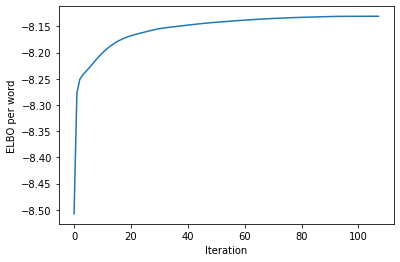

In [19]:
elbos, (q_c, q_pi, q_theta) = cavi(docs)

plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO per word")

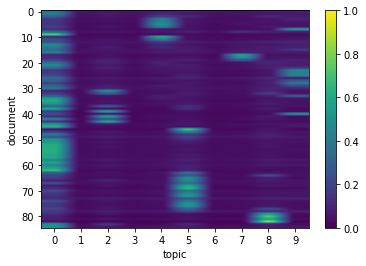

In [20]:
topic_usage = q_pi.mean
plt.imshow(topic_usage, aspect="auto", vmin=0, vmax=1)
plt.xticks(torch.arange(topic_usage.shape[1]))
plt.xlabel("topic")
plt.ylabel("document")
plt.colorbar()

In [72]:
# Analyze the topics
usage = q_pi.mean
topics = q_theta.mean

# Sort the topics by usage
topic_perm = torch.argsort(usage.sum(0), descending=True)
usage = usage[:, topic_perm]
topics = topics[topic_perm]

keywords = []
for k, topic in enumerate(topics):
    # if torch.allclose(usage[k], usage.min()):
    #     continue
    print("topic ", k, "usage : ", usage[k])
    
    inds = torch.argsort(topic, descending=True)
    keywords.append(vocab[inds[0]])
    for i, ind in enumerate(inds[:5]):
        print("\t", vocab[ind], ":", topic[ind])
    print("")

topic  0 usage :  tensor([0.3847, 0.0888, 0.0834, 0.0931, 0.0613, 0.0777, 0.0585, 0.0508, 0.0508,
        0.0508])
	 people : tensor(0.0149)
	 federal : tensor(0.0077)
	 national : tensor(0.0070)
	 union : tensor(0.0062)
	 representatives : tensor(0.0058)

topic  1 usage :  tensor([0.4278, 0.0656, 0.0646, 0.0685, 0.0777, 0.1051, 0.0534, 0.0457, 0.0457,
        0.0457])
	 executive : tensor(0.0141)
	 legislative : tensor(0.0097)
	 senate : tensor(0.0074)
	 body : tensor(0.0074)
	 president : tensor(0.0068)

topic  2 usage :  tensor([0.2959, 0.1060, 0.1093, 0.0754, 0.0586, 0.1825, 0.0463, 0.0420, 0.0420,
        0.0420])
	 cases : tensor(0.0093)
	 courts : tensor(0.0088)
	 jurisdiction : tensor(0.0065)
	 trial : tensor(0.0060)
	 court : tensor(0.0059)

topic  3 usage :  tensor([0.1641, 0.0610, 0.0538, 0.0989, 0.0484, 0.4167, 0.0448, 0.0374, 0.0374,
        0.0374])
	 peace : tensor(0.0058)
	 military : tensor(0.0055)
	 time : tensor(0.0049)
	 militia : tensor(0.0047)
	 war : tensor(0.004

## Exploring topics by author usage

Using the model, plot the total topic usage for each author

In [73]:
# load authorship and convert 
authors_df = pd.read_csv('authorship.csv', index_col = 0)
to_tensor = lambda df: torch.tensor(df.to_numpy())
author_names = ["HAMILTON", "JAY", "MADISON", "DISPUTED"]
authors = torch.column_stack([to_tensor(authors_df == name) 
                              for name in author_names])

In [74]:
author_usage = torch.row_stack([usage[authors[:, i]].mean(dim=0) for i in range(4)])

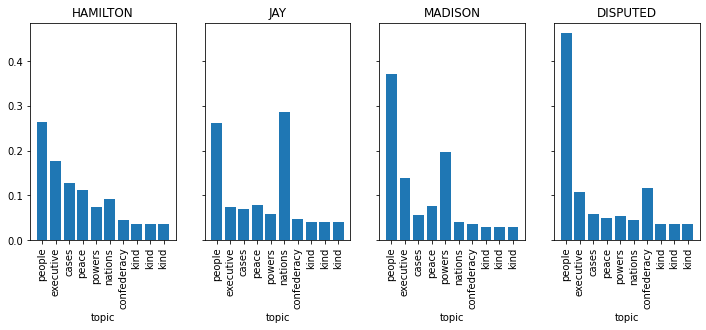

In [75]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4), sharey=True)
for ax, name, usage in zip(axs, author_names, author_usage):
    ax.bar(torch.arange(10), usage)
    ax.set_title(name)
    ax.set_xlabel("topic")
    ax.set_xticks(torch.arange(10))
    ax.set_xticklabels(keywords, rotation=90)
    # ax.set_ylabel("usage")

## Conclusion

This notebook demonstrates a very naive implementation of CAVI for LDA and applies it to the Federalist papers -- a collection of documents authored by Hamilton, Jay, and Madison that were influential in forming the US Constitution. 

There are many ways this implementation could be improved. For example,
- While it does work with word counts, it does not take advantage of the sparsity of the data matrix. It explicitly instantiates parameters for the posterior over $c_{n,v}$ even when $y_{n,v}=0$. We could improve performance by leveraging this sparsity.

- It operates in "batch mode," which is fine for small datasets like this one, but can become intractable for massive corpora, like all the pages of Wikipedia. For those regimes, it is better to work with _stochastic variational inference_ (Hoffman et al, 2011).